## A BRIEF LOOK AT TURKISH ECONOMICS

Most of the data in this analysis comes from Turkey's Central Bank (TCMB) for now. The larger data from the TUIK (Turkish Statistics Institute) is going to be added.

### INTRODUCTION

1. The data in this project come from https://evds2.tcmb.gov.tr, the website of the Turkish Central Bank.

2. The project is still in progress. So far some data collection and initial analyses are done.

3. Currently we have data for:
     
     * External debts

     * GDP (only cumulative and un-used for now)
     
     * Price Indices (production and consumption) 
     
     * Privatisation Gains (only total monatery gains)
     
     * Sectoral employment
     
     * Sectoral production
     
     * Gold, currency.
     
4) To be added:

    * Nominal GDPPPP
    
    * Privatisation sectors and targets
    
    * Unemployment numbers (including gender).
    
    * Production and private sector firm's numbers per sector (especially textile, agriculture, mining and heavy industry)
    
    
    
    


### Importing Modules

In [30]:
# for general control
import datetime as dt
import time
import sys
import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
import scipy.stats
from scipy.optimize import curve_fit
from lmfit import Model
from lmfit.models import SkewedGaussianModel

# for data handling
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import re

# for plotting
import matplotlib.pyplot as plt
import matplotlib as mplib
from matplotlib import rc
import seaborn as sns
# show matlplotlib output in notebook
%matplotlib inline

# for machine learning
import sklearn

### Column Names

The column list of the data set is defined here based on the information from the TCMB data page: https://evds2.tcmb.gov.tr

This can be made in a more elegant way later.

In [95]:
filenames = ['EVDS_disborc.xlsx','EVDS_ithalat_ihracat.xlsx','EVDS_gsyh_firma.xlsx',
            'EVDS_istihdam_butce.xlsx','EVDS_privatisation.xlsx','EVDS_uretim.xlsx']

# External Debt data
ext_debt_col = ["Date","Total_Debt","Short","Long_4A","Long_State_Owned",\
                        "Long_4B","Private","Financial_Inst","Finance_woBanks",\
                        "Private_Invest","Commercial_Banks","Official","Governmental",\
                        "International","IMF","Other_international"]

# Import - Export - Consumer Prices
imp_exp_col = ["Date","Living","Health","Education","Food_Drinks","Food",\
                        "Export","Import","Invest_export","Invest_import",\
                        "Consume_export","Consume_Import"]

# Import - Export: GDP
gdp_in_col = ["Date","GDP_consumer","GDP_earnings","New_Firms","New_Firms_Finance","Closing"]

# Privatisation
priv_in_col = ["Date","Priv_Gain"]

# Employment - Budget
emp_bud_col = ["Date","Help_Pol_Par","Agri_support","Animal_support",\
               "Agri_Reform_Proj","Tot_Emp","Emp_agr_fors_fish","Mining",
               "Production","Elec_Gas_Hydro_Water_Canalisation","Building",\
               "Wholesale_Single","Transport","Communication","Finance_Insurance",\
               "Immovable","Scientific_Technical","Management_support",\
               "Public_and_Defense", "Education","Health_Social",\
               "Culture_Art_Sport","Other_public"]

# Production
prod_col = ["Date","Prod_elec(GWh)","Prod_export","Prod_import","Consump",\
            "Tot_Industry","Mining","Production","Coal_Lignite","Prod_food",
            "Prod_textile","Prod_chemical"]

# Gold and Exchange Rate
gold_exc_col = ["Date","Gold_sales","Gold_price_ind","Official_gold_price","Ounce_Gold_London",\
           "Euro","Effective_exch"]

### Function to read the Excel files

In [96]:
def read_data_in(file_in,column_list,lines):
    """Function to quickly read a number of lines from Excel and rename the columns for each\
    data"""
    indat = pd.read_excel(file_in)
    indat = indat.loc[0:lines]
    indat.columns = column_list
    return indat


### Read Data In

In [97]:
# External Debts
ext_debt_in = read_data_in('EVDS_disborc.xlsx', ext_debt_col, 28)


# Import Export data
imp_exp_in  = read_data_in('EVDS_ithalat_ihracat.xlsx', imp_exp_col, 149)
# converting all to float
imp_exp_in[["Health","Living"]] = imp_exp_in[["Health","Living"]].apply(pd.to_numeric)



# GDP data  (converting to millions)
gdp_in  = read_data_in('EVDS_gsyh_firma.xlsx', gdp_in_col, 20)
gdp_in[["GDP_consumer","GDP_earnings"]] = \
       gdp_in[["GDP_consumer","GDP_earnings"]].apply(lambda x: x/10**6)

    
    
# Privatisation data and conversion to billions of dollars
priv_in = read_data_in('EVDS_privatisation.xlsx',priv_in_col,32)
priv_in["Priv_Gain"] = priv_in["Priv_Gain"]/10**6.
Total_gains = priv_in["Priv_Gain"].sum()
nr_years  = max(priv_in["Date"]) - min(priv_in["Date"])
print(int(Total_gains)/1000, "Billions of Dollars gained from privatisation of State assets, in", nr_years,"years")



# Employment_Budget (employment given in 1000s)
emp_bud_in = read_data_in('EVDS_istihdam_butce.xlsx', emp_bud_col, 148)
emp_bud_in[["Help_Pol_Par","Agri_support"]] = emp_bud_in[["Help_Pol_Par","Agri_support"]].apply(pd.to_numeric)
emp_bud_in.iloc[:,5:] = emp_bud_in.iloc[:,5:].apply(lambda x: x*1000)
emp_bud_in.iloc[:,1:5] = emp_bud_in.iloc[:,1:5].apply(lambda x: x*1000)#TL



# Production
prod_col_in = read_data_in('EVDS_uretim.xlsx', prod_col, 37)


# Gold_exchange_rate
gold_exc_in = read_data_in('EVDS_altin_doviz.xlsx',gold_exc_col,149)
gold_exc_in[["Gold_sales","Gold_price_ind"]] = gold_exc_in[["Gold_sales","Gold_price_ind"]].\
apply(pd.to_numeric)


(68, 'Billions of Dollars gained from privatisation of State assets, in', 31, 'years')


### Data Transformation



Converting the column Data that has monthly data to a simple year columns.



In [58]:
def convert_date(datafr):
    """Function cleaning the data column. """
    # Delete detail
    datafr["Date"] = datafr["Date"].str.split('-',n=1, expand = True)[0]
    datafr["Date"] = pd.to_numeric(datafr["Date"])
    #summarise with mean
    datafr = datafr.groupby(["Date"]).mean() 
    datafr = datafr.reset_index()

    return datafr


In [59]:
imp_exp_in = convert_date(imp_exp_in) 
prod_col_in = convert_date(prod_col_in)
emp_bud_in = convert_date(emp_bud_in)
gold_exc_in = convert_date(gold_exc_in)

In [60]:
imp_exp_in.head(1)
gold_exc_in.head(1)


,Date,Living,Health,Education,Food_Drinks,Food,Export,Import,Invest_export,Invest_import,Consume_export,Consume_Import
0,2005,126.06,111.75,140.69,116.08,115.7,7246.279,11682.578,752.18,2372.985,3404.019,1558.103


,Date,Gold_sales,Gold_price_ind,Official_gold_price,Ounce_Gold_London,Euro,Effective_exch
0,2006,NaN,1386.435881,193.273333,608.125,1.255533,106.7675


### Plotting Function

In [75]:
def plot_pathways(dataset,var_col,date_col = "Date", pl_title = "", ylab = "",\
                  data_opt = "",var_opt = "", date_opt = "Date", ftype = "1"):
    """Function that can plot the time series for all data.
    Default is to plot multiple columns of a single data set.
    It can however, take two data sets as arguments to be 
    plotted together"""
    
    new_pl = plt.figure()
    # First checking whether we need to do anything for the optional data
    if len(data_opt) != 0:
        opt = 1
        for i in var_opt:
            if type(i)==int:
                current_opt = data_opt.iloc[:,i]
            elif type(i)==str:
                current_opt = data_opt.loc[:,i]
            else:
                print("Error: You have a column name that is not an integer or string in the\
                OPTIONAL data frame", i, type(i))
                break
    else:
        opt = 0
        #print("No additional data given")

    # Now the main data set is subset
    for j in var_col:
        if type(j)==int:
            current = dataset.iloc[:,j]
        elif type(j)==str:
            current = dataset.loc[:,j]
        else:
            print("Error: You have a column name that is not an integer or string", j, type(j))
            break

        if opt == 0:
            new_pl = plt.plot(dataset[[date_col]],current, label=j)
        elif opt == 1:
            new_pl = plt.plot(dataset[[date_col]],current )
        new_pl = plt.title(pl_title)
        new_pl = plt.ylabel(ylab)    
               
    if opt == 1:
        if ftype == "logy":
            new_pl = plt.semilogy(data_opt[[date_col]],current_opt)  
        else:
            new_pl = plt.plot(data_opt[[date_col]],current_opt)  
 
    new_pl = plt.legend()
    #return new_pl
 

### Exploratory Data Analysis

#### 1. Help to the Political Parties as percentage of Budget

The 10-fold increase in the last 10 years, in the help to political parties from the state budget.

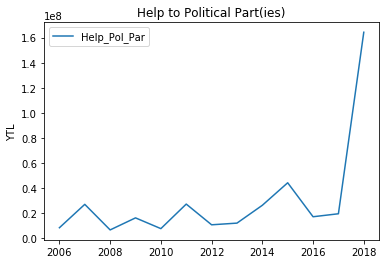

In [76]:

plot_pathways(emp_bud_in,["Help_Pol_Par"],"Date", pl_title = "Help to Political Part(ies)",\
                ylab = "YTL")


#### 2. Exponential increase of the Consumer Price Index for food.

In the news, it is reported that basic food such as onions and tomatoes are getting very expensive day by day. The figure support the hypothesis that the food prices seem to increase much faster than average inflation. This will be later modelled against fuel prices and exchange rate.

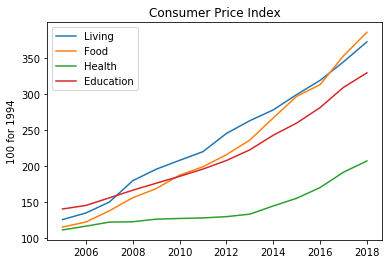

In [77]:
plot_pathways(imp_exp_in,["Living","Food","Health","Education"],"Date",\
              "Consumer Price Index","100 for 1994")



#### 3. External debts also increasing fast

Similarly and worryingly, external debst seem to grow exponentially too. Also the debts of the private sector, especially now that the currency lost 50% value in the last 5 years is worrying.

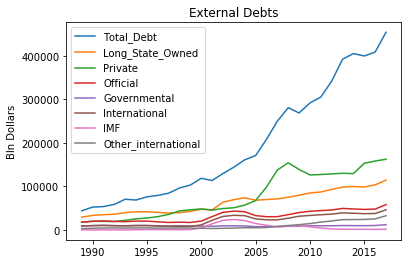

In [88]:
plot_pathways(ext_debt_in, ["Total_Debt","Long_State_Owned","Private","Official",\
                            "Governmental","International","IMF",\
                            "Other_international"],"Date", "External Debts", "Bln Dollars")



#### 4. Gains from Privatisation

TO BE CLARIFIED: Despite the increase of gains from privatisation, the overall gain might not be quite as strong as suggested by the figure. The interesting data to find is the actual value of the institutions sold through privatisation. 

Combined with the sales of major investment institutions founded early in the Turkish Republic's life, like Sümerbank and Etibank that had large market shares in the textile and electricity/mining, as well as the increasing debts of all but especially the private sector, can impact the economy in the coming years. Sümerbank is an interesting case that can be studied separately. Always reporting gains until the late 80s, its value decreased substantially at the time as it got into the privatisation list. Especially as its immovables has been transferred freely to other institutions its debts increased drastically and it finally got privatised in 2004. 
https://www.evrensel.net/haber/146731/bir-ozellestirme-romani-sumerbank

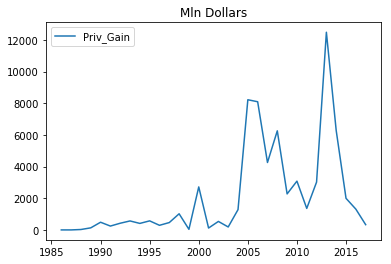

In [93]:
# For privatisation vs debt, using log scale
plot_pathways(priv_in,["Priv_Gain"], "Date","Mln Dollars")


#### 4. Number of newly opening and closing firms

This data shows a large number of new companies being open, very likely related to the growth rate.

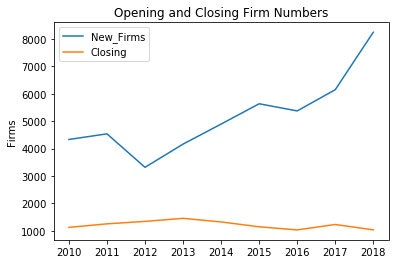

In [94]:
plot_pathways(gdp_in,["New_Firms","Closing"],"Date",\
              "Opening and Closing Firm Numbers","Firms")


In [ ]:
# Writing a fine-tuned linear regression model

def linreg(x,y, islog = False):
    """Minimising the distance between data and a regression line of y = ax + b"""

    # normalisation of y and the constants
    if islog == True:
        y = np.log(y)

    # Normalisation
    norm_cte = max(y)
    y = y/norm_cte 
    b = min(y) 
    slope_guess = (y[(len(x)-1)] - y[0]) / (x[(len(x)-1)] - x[0])

    # number of iterations to find the slope
    n_try = 151
    k = -n_try*1/2
    
    a_list = np.zeros(n_try)
    dist = np.zeros(n_try)
    for j in range(n_try):
        k = k + 1
        
        # allowing a slope range of -+1.5 times the slope between the first and last points.
        a = slope_guess * ( 1 + float(k) / n_try ) 

        y_cal = np.empty(len(y))
        dist_s = np.zeros(len(y_cal))
        for i in range(len(x)):
            y_cal[i] = a * x[i] + b
        
        # Least-Squares: The distance of every fit point to the actual data
            dist_s[i] = (y_cal[i] - y[i])**2
        dist[j] = math.sqrt(sum(dist_s))
        a_list[j] = a
    
    # Find the slope that gave the minimum lsq.
    index = np.where(dist==min(dist))
    a_min = a_list[index]
    return index, min(dist), b, a_min,norm_cte

In [ ]:
ind, mdist, b, a, norm_cte = linreg(imp_exp_in.index,imp_exp_in["Import"])

In [ ]:
def plot_reg(x,y, islog = False):
    reg_line =np.empty(len(x))
    plt.plot(x,y,'*')
    
    for i in range(len(x)):
        if islog == True:
            reg_line[i] = np.exp((a*x[i] +b)* norm_cte)
            fcol = "m"
            ftitl = "Exponential fit"
        elif islog == False :
            reg_line[i] = (a*x[i] +b)* norm_cte
            fcol = "r"
            ftitl="Linear fit"
    plt.plot(x,reg_line, color = fcol,)
    plt.title(ftitl)
    plt.xlabel("Year")
    plt.ylabel("Food Price index")

### Do the food prices increase exponentially?

In [ ]:
ind, mdist, b, a, norm_cte = linreg(imp_exp_in.index,imp_exp_in["Food"])
plot_reg(imp_exp_in.index,imp_exp_in["Food"])

#Let's fit an Exponential
ind, mdist, b, a, norm_cte = linreg(imp_exp_in.index,imp_exp_in["Food"],True)

plt.figure()
plot_reg(imp_exp_in.index,imp_exp_in["Food"], True)


Unfortunately!

### EMPLOYMENT DATA
 Get unemployment per sector too


In [ ]:
### EMPLOYMENT DATA
columns = []
columns.append(0)
columns[1:len(emp_bud_in.columns)] = range(5,len(emp_bud_in.columns))

# Choosing employment data
emp_data = emp_bud_in.iloc[:,columns]
emp_data = emp_data.set_index(["Date"])
fig = emp_data.plot.line(legend = False, xlim = [2008,2015])
plt.show()

### Which sectors employ most people?


In [ ]:
emp_data.index

emp_data.describe().max().plot.bar(title = "Overall")
plt.show()
emp_data.loc[float(2014)].plot.bar(title = "2014")
plt.show()




In [ ]:
plot_pathways(emp_data, [""])